## Prédiction de ventes

### Exploration du dataset

In [1]:
# importer les librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn.linear_model import LinearRegression 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from xgboost import XGBRegressor

from preprocessing import create_lags, create_rolling_average, create_temporalities, cyclical_encoding

In [2]:
# chargement du dataset
df = pd.read_csv('./data/PJME_hourly.csv', parse_dates=['Datetime'], index_col=['Datetime'])
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<Axes: xlabel='Datetime'>

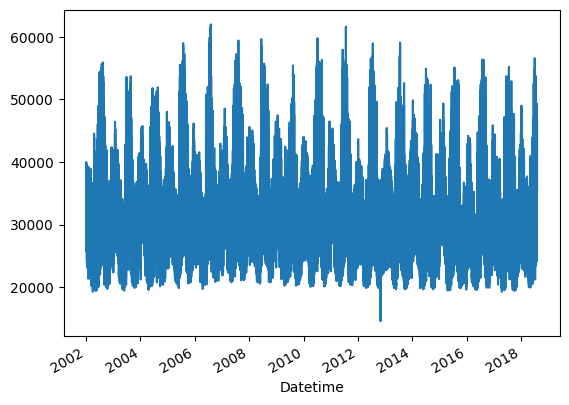

In [3]:
# Afficher le graphique de la colonne principale du df
df['PJME_MW'].plot()

#### Feature engineering

In [4]:
create_temporalities(dataframe=df)

In [5]:
df.head(1)

,PJME_MW,heure,jour,semaine,mois,trimestre,annee
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,31,1,12,4,2002


In [6]:
# col_temporalities = ['heure', 'jour', 'semaine', 'mois', 'trimestre', 'annee']

# for col in col_temporalities:

#     cyclical_encoding(dataframe=df, col=col)

In [7]:
# Appliquer les fonctions pour les lags et les rollings
create_lags(dataframe=df)
create_rolling_average(dataframe=df)

In [8]:
df.head()

,PJME_MW,heure,jour,semaine,mois,trimestre,annee,lags_364,lags_728,lags_1092,lags_1456,rolling_6
Datetime,,,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,31,1,12,4,2002,NaN,NaN,NaN,NaN,NaN
2002-12-31 02:00:00,25147.0,2,31,1,12,4,2002,NaN,NaN,NaN,NaN,NaN
2002-12-31 03:00:00,24574.0,3,31,1,12,4,2002,NaN,NaN,NaN,NaN,NaN
2002-12-31 04:00:00,24393.0,4,31,1,12,4,2002,NaN,NaN,NaN,NaN,NaN
2002-12-31 05:00:00,24860.0,5,31,1,12,4,2002,NaN,NaN,NaN,NaN,NaN


#### Preprocessing (train_test_split)

In [9]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [10]:
# Définir une période limite pour l'entrainement
limit_date = '2014-01-01'

# Time series train test split
train_data = df[df.index < limit_date]
test_data = df[df.index >= limit_date]

In [11]:
# vérification des shape
df.shape, train_data.shape, test_data.shape

((145366, 12), (105166, 12), (40200, 12))

In [12]:
df.columns

Index(['PJME_MW', 'heure', 'jour', 'semaine', 'mois', 'trimestre', 'annee',
       'lags_364', 'lags_728', 'lags_1092', 'lags_1456', 'rolling_6'],
      dtype='object')

In [13]:
# Affecter x et y
X_train = train_data[['heure', 'jour', 'semaine', 'mois', 'trimestre', 'annee',
                      'lags_364', 'lags_728', 'lags_1092']]

X_test = test_data[['heure', 'jour', 'semaine', 'mois', 'trimestre', 'annee',
                      'lags_364', 'lags_728', 'lags_1092']]

y_train= train_data['PJME_MW']
y_test= test_data['PJME_MW']

In [14]:
# shape
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(105166, 9) (40200, 9)
(105166,) (40200,)


In [15]:
# Preprocessing

categorical_variable = X_train.select_dtypes('object').columns
numerical_variable = X_train.select_dtypes(np.number).columns

categorical_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                     OneHotEncoder(handle_unknown='ignore', sparse=False))

numerical_pipeline = make_pipeline(StandardScaler()) # KNNImputer(n_neighbors=5) 
                                                      # ne pas mettre le knn par rapport aux lags

preprocessing = make_column_transformer((categorical_pipeline, categorical_variable),
                                        (numerical_pipeline, numerical_variable))

#### Modélisation

In [16]:
# Instanciation du modele

estimator = XGBRegressor()

model = make_pipeline(preprocessing, estimator)

In [17]:
# Entrainement
model.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index([], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['heure', 'jour', 'sema...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [18]:
# cross_validation : time serie split

tss = TimeSeriesSplit(n_splits=4)

result = cross_val_score(model, 
                X_train,
                y_train, 
                scoring='neg_root_mean_squared_error',
                cv=tss)

# moyenne avec abs() et mean()
abs(result.mean())

5025.502145052344

#### Fine-Tuning

In [19]:
# Randomizesearchcv

# model.get_params()
params = {'xgbregressor__n_estimators': [200,300,400,500],
          'xgbregressor__max_depth': [6,8,10],
          'xgbregressor__learning_rate': [00.1, 0.1],
          'xgbregressor__colsample_bytree': [0.6, 0.8, 1],
          'xgbregressor__subsample': [0.6, 0.8, 1],
          'xgbregressor__booster': ['gbtree'],
          'xgbregressor__n_jobs':[10]
          }

grid = RandomizedSearchCV(estimator=model, 
                          param_distributions=params, 
                          scoring='neg_root_mean_squared_error',
                          n_iter=1,
                          random_state=101,
                          cv = tss)

grid.fit(X_train, y_train)


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               Index([], dtype='obje...
                   n_iter=1,
                   param_distributions={'xgbregressor__booster': ['gbtree'],
                                        'xgbregressor__colsample_bytree': [0.6,
                                                                           0.8,
                                                                           1],
                                        'xgbregressor__learning_rate': [0.1,
                                                                        0.1],
                                        'xgbregressor__max_depth': [6, 8, 10],
                                        'xgbregressor__n_estimators': [200, 300,
                                                                       400,
                                                                       500],
                                        'xgbregressor__n_jobs': [10],
                                        'xgbregressor__subsample': [0.6, 0.8,
                                                                    1]},
                   random_state=101, scoring='neg_root_mean_squared_error')

In [20]:
print(grid.best_params_)
print(grid.best_score_)

model_final = grid.best_estimator_

{'xgbregressor__subsample': 1, 'xgbregressor__n_jobs': 10, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 8, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.8, 'xgbregressor__booster': 'gbtree'}
-4756.072552114104


In [21]:
# predictions
y_pred = model_final.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

4254.7538356098

In [22]:
evaluation = pd.DataFrame(y_test)
evaluation['prediction'] = y_pred
evaluation.rename(columns = {'PJME_MW': 'real_values'}, inplace=True)
evaluation.head()

,real_values,prediction
Datetime,,
2014-01-01 00:00:00,32595.0,29650.914062
2014-12-31 01:00:00,30795.0,30209.093750
2014-12-31 02:00:00,29995.0,29515.617188
2014-12-31 03:00:00,29688.0,28381.207031
2014-12-31 04:00:00,29767.0,27563.939453


<Axes: xlabel='Datetime'>

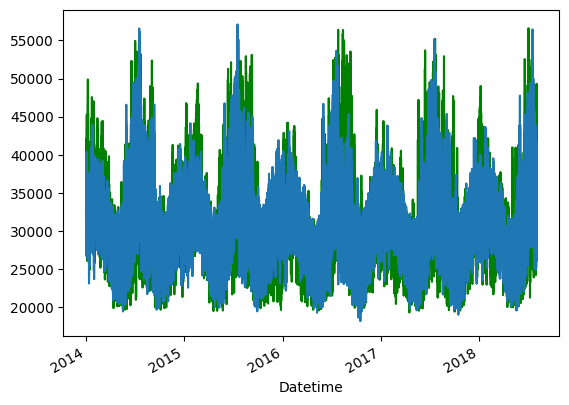

In [23]:
# Comparer les prédictions aux valeurs réelles
evaluation['real_values'].plot(c='green')
evaluation['prediction'].plot()

### Feature importance

In [25]:
# Feature importance
import xgboost 


In [98]:
feature_score = model_final.named_steps['xgbregressor'].get_booster().get_score(importance_type = 'weight')
feature_score_df = pd.DataFrame(feature_score.items())
feature_score_df.rename({0:'feature',1: 'importance'}, axis=1, inplace=True)
feature_score_df = feature_score_df.sort_values(by='importance', ascending=False)
feature_score_df

,feature,importance
1,jour,16646.0
6,lags_364,15374.0
2,semaine,14225.0
7,lags_728,13568.0
8,lags_1092,12892.0
0,heure,9967.0
5,annee,9679.0
3,mois,4273.0
4,trimestre,164.0


<Axes: xlabel='importance', ylabel='feature'>

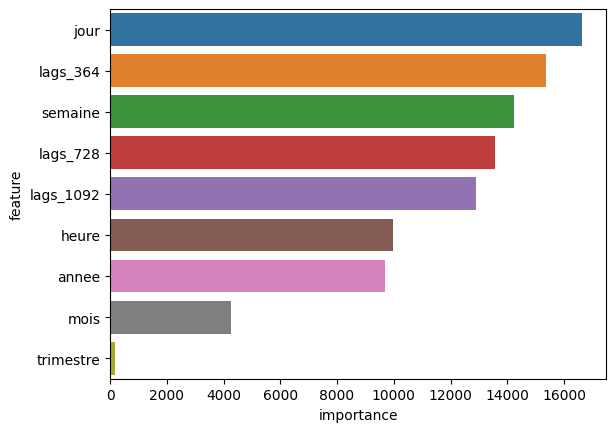

In [100]:
sns.barplot(x=feature_score_df['importance'], y=feature_score_df['feature'])

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

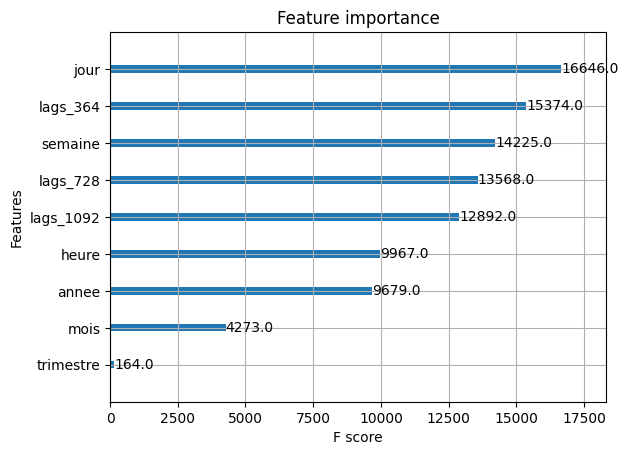

In [76]:
# 2 eme méthode
cols_name = list(X_train.columns)

model_final.named_steps['xgbregressor'].get_booster().feature_names = cols_name
xgboost.plot_importance(model_final.named_steps['xgbregressor'])

## Forecasting in the future 

In [29]:
# Verifier la derniere date
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [30]:
# créer la future période
futur = pd.date_range('2018-08-03', '2019-08-03', freq='1h')
# créer un index pour prédire
df_futur = pd.DataFrame(index=futur)
df_futur['is_futur'] = True
df['is_futur'] = False
df_and_future = pd.concat([df, df_futur])


In [54]:
# Créer des temporalités pour le futur

create_temporalities(dataframe=df_and_future)
create_lags(dataframe=df_and_future)
# create_rolling_average(dataframe=df_and_future)
df_and_future.tail(2)

,PJME_MW,heure,jour,semaine,mois,trimestre,annee,lags_364,lags_728,lags_1092,lags_1456,rolling_6,is_futur
2019-08-02 23:00:00,NaN,23,2,31,8,3,2019,NaN,NaN,NaN,NaN,NaN,True
2019-08-03 00:00:00,NaN,0,3,31,8,3,2019,NaN,NaN,NaN,NaN,NaN,True


In [55]:
# # Réentrainer sur tout le dataset (df original)
# # Définir une période limite pour l'entrainement
# limit_date = '2018-08-03'

# # Time series train test split
# train_data = df_and_future[df_and_future.index < limit_date]
# test_data = df_and_future[df_and_future.index >= limit_date]

In [56]:
# train_data.columns

In [57]:
# # Affecter x et y
# X_train = train_data[['heure', 'jour', 'semaine', 'mois', 'trimestre', 'annee',
#                       'lags_2', 'lags_3', 'lags_4', 'rolling_6',]]

# X_test = test_data[['heure', 'jour', 'semaine', 'mois', 'trimestre', 'annee',
#                       'lags_2', 'lags_3', 'lags_4', 'rolling_6',]]

# y_train= train_data['PJME_MW']
# y_test= test_data['PJME_MW']

In [58]:
# # Preprocessing

# categorical_variable = X_train.select_dtypes('object').columns
# numerical_variable = X_train.select_dtypes(np.number).columns

# categorical_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), 
#                                      OneHotEncoder(handle_unknown='ignore', sparse=False))

# numerical_pipeline = make_pipeline(StandardScaler()) # KNNImputer(n_neighbors=5) 
#                                                       # ne pas mettre le knn par rapport aux lags

# preprocessing = make_column_transformer((categorical_pipeline, categorical_variable),
#                                         (numerical_pipeline, numerical_variable))

In [59]:
# # Instanciation du modele

# estimator = XGBRegressor()

# model = make_pipeline(preprocessing, estimator)

# # Evaluation du modele
# model.fit(X_train,y_train)

In [60]:
# # cross_validation : time serie split

# tss = TimeSeriesSplit(n_splits=4)

# result = cross_val_score(model, 
#                 X_train,
#                 y_train, 
#                 scoring='neg_root_mean_squared_error',
#                 cv=tss)

# # moyenne avec abs() et mean()
# abs(result.mean())

In [61]:
final_forcasting_df = df_and_future.query('is_futur').copy()
final_forcasting_df.tail(1)


,PJME_MW,heure,jour,semaine,mois,trimestre,annee,lags_364,lags_728,lags_1092,lags_1456,rolling_6,is_futur
2019-08-03,NaN,0,3,31,8,3,2019,NaN,NaN,NaN,NaN,NaN,True


### Fine-tuning

#### Prédictions futures

In [62]:
# Récupérer le nom des colonnes
columns_name = X_test.columns
columns_name = list(columns_name)

In [63]:
# créer une colonne pred pour les prédictions
final_forcasting_df['pred'] = model_final.predict(final_forcasting_df[columns_name])

<Axes: title={'center': 'Predictions futures'}>

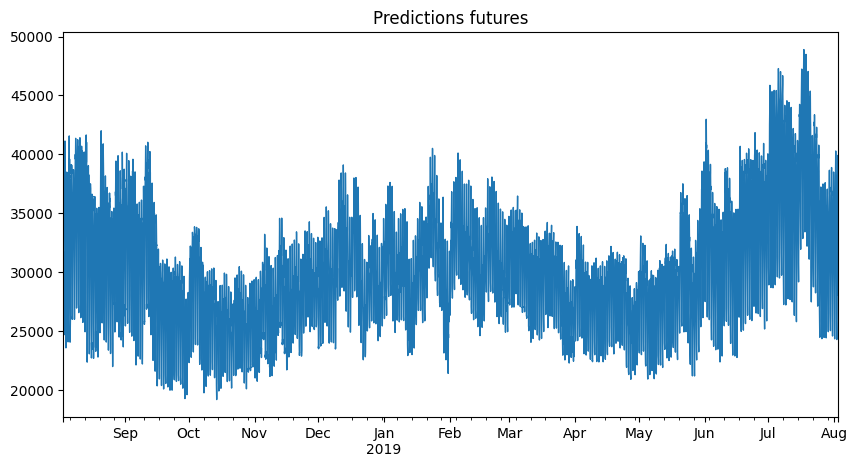

In [64]:
# Afficher les prédictions
final_forcasting_df['pred'].plot(figsize=(10,5),
                                 ms=1,
                                 lw=1,
                                 title='Predictions futures')

In [65]:
# Concaténer les deux dataframes (le premier dataframe et le dataframe des prédictions sur le futur)
pred_final = pd.concat([df, final_forcasting_df])
pred_final.head(3)

,PJME_MW,heure,jour,semaine,mois,trimestre,annee,lags_364,lags_728,lags_1092,lags_1456,rolling_6,is_futur,pred
2002-12-31 01:00:00,26498.0,1,31,1,12,4,2002,NaN,NaN,NaN,NaN,NaN,False,NaN
2002-12-31 02:00:00,25147.0,2,31,1,12,4,2002,NaN,NaN,NaN,NaN,NaN,False,NaN
2002-12-31 03:00:00,24574.0,3,31,1,12,4,2002,NaN,NaN,NaN,NaN,NaN,False,NaN


In [66]:
# Enregistrement dans un csv
pred_final.to_csv('./data/df_pred_futur.csv', index=False)

In [67]:
# derniere date du dataframe
df.index.max()

Timestamp('2018-08-03 00:00:00')

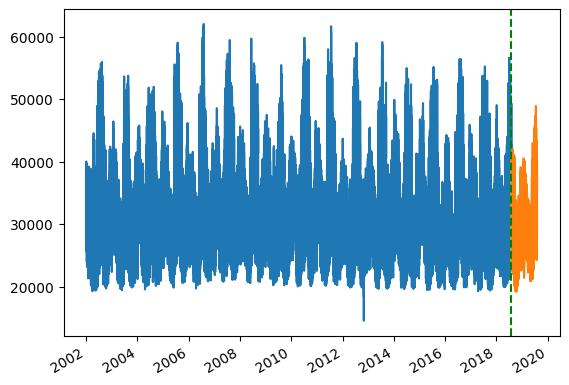

In [68]:
# Visualisation des données réelles et des prédictions sur le futur
# données reelles
pred_final['PJME_MW'].plot()
#données prédites
pred_final['pred'].plot()
plt.axvline(x='2018-08-03', color='green', ls='--')